# ArbitraryDiscretiser + MeanEncoder

This is very useful for linear models, because by using discretisation + a monotonic encoding we create monotonic variables, from those that before were not originally. And this tends to hep improve the performance of the model. 

## ArbitraryDiscretiser

The ArbitraryDiscretiser() divides continuous numerical variables
into contiguous intervals are arbitrarily entered by the user.

The user needs to enter a dictionary with variable names as keys, and a list of
the limits of the intervals as values. For example {'var1': [0, 10, 100, 1000],
'var2': [5, 10, 15, 20]}.

<b>Note:</b> Read ArbitraryDiscretiser notebook to know more about this transformer

## MeanEncoder

The MeanEncoder() replaces the labels of the variables by the mean value of the target for that label. <br>For example, in the variable colour, if the mean value of the binary target is 0.5 for the label blue, then blue is replaced by 0.5

<b>Note:</b> Read MeanEncoder notebook to know more about this transformer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import ArbitraryDiscretiser
from feature_engine.encoding import MeanEncoder
from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = [15,5]

In [7]:
# Load titanic dataset from OpenML

def load_titanic():
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['age'] = data['age'].astype('float').fillna(data.age.median())
    data['fare'] = data['fare'].astype('float').fillna(data.fare.median())
    data['embarked'].fillna('C', inplace=True)
    data.drop(labels=['boat', 'body', 'home.dest'], axis=1, inplace=True)
    return data

In [8]:
data = load_titanic()
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C,S


In [14]:
# let's separate into training and testing set
X = data.drop(['survived', 'name', 'ticket'], axis=1)
y = data.survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train :" ,X_train.shape)
print("X_test :" ,X_test.shape)

X_train : (916, 8)
X_test : (393, 8)


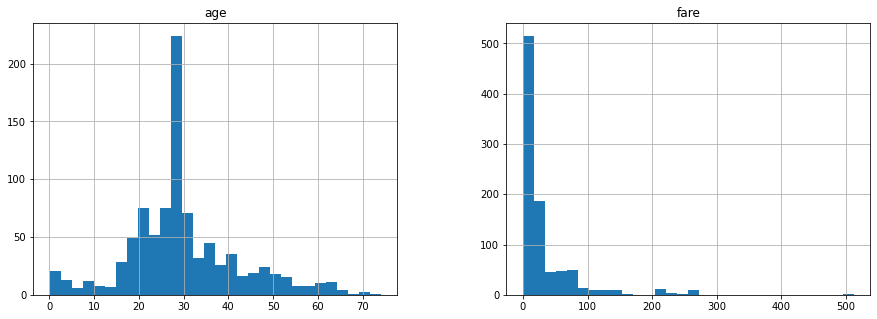

In [10]:
# we will use two continuous variables for transformation
X_train[["age", 'fare']].hist(bins=30)
plt.show()

In [16]:
# pipeline 
arb_disc = ArbitraryDiscretiser(binning_dict={'age':[-np.inf,0,25,50,75,np.inf],
                                             'fare':[-np.inf,0,20,40,60,80,np.inf]},
                               return_object=True)#returns values as categorical

transformer = Pipeline(steps=[('ArbitraryDiscretiser',arb_disc),
                              ('MeanEncoder',MeanEncoder(variables=['age','fare']))
                             ])
transformer.fit(X_train,y_train)

Pipeline(steps=[('ArbitraryDiscretiser',
                 ArbitraryDiscretiser(binning_dict={'age': [-inf, 0, 25, 50, 75,
                                                            inf],
                                                    'fare': [-inf, 0, 20, 40,
                                                             60, 80, inf]},
                                      return_object=True)),
                ('MeanEncoder', MeanEncoder(variables=['age', 'fare']))])

In [17]:
transformer.named_steps['ArbitraryDiscretiser'].binner_dict_

{'age': [-inf, 0, 25, 50, 75, inf], 'fare': [-inf, 0, 20, 40, 60, 80, inf]}

In [18]:
transformer.named_steps['MeanEncoder'].encoder_dict_

{'age': {1: 0.41414141414141414, 2: 0.3664259927797834, 3: 0.4153846153846154},
 'fare': {0: 0.14285714285714285,
  1: 0.29206963249516443,
  2: 0.43283582089552236,
  3: 0.5636363636363636,
  4: 0.45652173913043476,
  5: 0.7349397590361446}}

In [21]:
train_t = transformer.transform(X_train)
test_t = transformer.transform(X_test)

test_t.head()

c:\users\king_ashok\desktop\feature_engine\feature_engine\encoding\base_encoder.py:79: UserWarning: NaN values were introduced in the returned dataframe by the encoder.This means that some of the categories in the input dataframe were not present in the training set used when the fit method was called. Thus, mappings for those categories does not exist. Try using the RareLabelCategoricalEncoder to remove infrequent categories before calling this encoder.
  "NaN values were introduced in the returned dataframe by the encoder."


,pclass,sex,age,sibsp,parch,fare,cabin,embarked
1139,3,male,0.366426,0,0,0.292070,n,S
533,2,female,0.414141,0,1,0.432836,n,S
459,2,male,0.366426,1,0,0.432836,n,S
1150,3,male,0.366426,0,0,0.292070,n,S
393,2,male,0.414141,0,0,0.432836,n,S


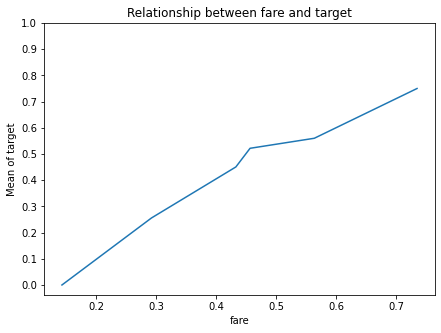

In [22]:
# let's explore the monotonic relationship
plt.figure(figsize=(7,5))
pd.concat([test_t,y_test], axis=1).groupby("fare")["survived"].mean().plot()
#plt.xticks([0,1,2])
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Relationship between fare and target")
plt.xlabel("fare")
plt.ylabel("Mean of target")
plt.show()